In [ ]:
import json
import requests
import time
import random
import csv
from tqdm import tqdm

# Load JSON entries
with open("/content/krutrim_nlpaueb_responses.json", "r") as f:
    entries = json.load(f)

# Gemini API setup
api_key = ""  # Make sure this is defined above or replace with your actual API key
url = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent?key={api_key}"
headers = {"Content-Type": "application/json"}

def exponential_backoff_request(payload, max_retries=5):
    wait = 1
    for attempt in range(max_retries):
        response = requests.post(url, headers=headers, json=payload)
        if response.status_code == 200:
            return response
        elif response.status_code in [429, 500, 502, 503, 504]:
            time.sleep(wait + random.uniform(0, 1))
            wait *= 2
        else:
            print(f"Request failed ({response.status_code}): {response.text}")
            break
    return None

def get_gemini_rating(original_query, improved_query, final_response):
    prompt = (
        "Evaluate the following improved legal query and its final legal response based on two criteria:\n"
        "1. *Versatility (1–100): How expressive and legally comprehensive is the *Improved Query?\n"
        "2. *Relevance (1–100): How well does the *Final Response match the Improved Query?\n\n"
        "Provide only the two numeric scores in this format:\n"
        "Versatility: <score>\n"
        "Relevance: <score>\n\n"
        f"Original Query:\n{original_query}\n\n"
        f"Improved Query:\n{improved_query}\n\n"
        f"Final Response:\n{final_response}"
    )

    payload = {
        "contents": [{"parts": [{"text": prompt}]}]
    }

    response = exponential_backoff_request(payload)
    if response:
        try:
            text = response.json()["candidates"][0]["content"]["parts"][0]["text"]
            lines = text.strip().splitlines()
            versatility = int([l for l in lines if "Versatility" in l][0].split(":")[1].strip())
            relevance = int([l for l in lines if "Relevance" in l][0].split(":")[1].strip())
            return versatility, relevance
        except Exception as e:
            print("Parsing error:", e)
    return None, None

# Output CSV setup
output_file = "krutrim-roberta_ratings.csv"
with open(output_file, "w", newline='', encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["query", "query_score", "response_score"])

    # Process entries with progress bar
    for entry in tqdm(entries, desc="Rating Queries"):
        original_query = entry.get("Original Query", "").strip()
        improved_query = entry.get("Improved Query", "").replace("Improved Query:", "").strip()
        final_response = entry.get("Final Response", "").strip()

        if not improved_query or not final_response:
            continue

        query_score, response_score = get_gemini_rating(original_query, improved_query, final_response)

        if query_score is not None:
            writer.writerow([original_query, query_score, response_score])

Rating Queries: 100%|██████████| 51/51 [02:18<00:00,  2.71s/it]


In [ ]:
import csv
import requests
import time
import random
from tqdm import tqdm

# Gemini API setup
api_key = ""  # Make sure this is defined above or replace with your actual API key
url = f"https://generativelanguage.googleapis.com/v1beta/models/gemini-1.5-flash-latest:generateContent?key={api_key}"
headers = {"Content-Type": "application/json"}

def exponential_backoff_request(payload, max_retries=5):
    wait = 1
    for attempt in range(max_retries):
        response = requests.post(url, headers=headers, json=payload)
        if response.status_code == 200:
            return response
        elif response.status_code in [429, 500, 502, 503, 504]:
            time.sleep(wait + random.uniform(0, 1))
            wait *= 2
        else:
            print(f"Request failed ({response.status_code}): {response.text}")
            break
    return None

def get_gemini_rating(original_query, final_response):
    prompt = (
        "Evaluate the following improved legal query and its final legal response based on two criteria:\n"
        "1. *Versatility (1–100): How expressive and legally comprehensive is the *Improved Query?\n"
        "2. *Relevance (1–100): How well does the *Final Response match the Improved Query?\n\n"
        "Provide only the two numeric scores in this format:\n"
        "Versatility: <score>\n"
        "Relevance: <score>\n\n"
        f"Original Query:\n{original_query}\n\n"
        f"Final Response:\n{final_response}"
    )

    payload = {
        "contents": [{"parts": [{"text": prompt}]}]
    }

    response = exponential_backoff_request(payload)
    if response:
        try:
            text = response.json()["candidates"][0]["content"]["parts"][0]["text"]
            lines = text.strip().splitlines()
            versatility = int([l for l in lines if "Versatility" in l][0].split(":")[1].strip())
            relevance = int([l for l in lines if "Relevance" in l][0].split(":")[1].strip())
            return versatility, relevance
        except Exception as e:
            print("Parsing error:", e)
    return None, None

# Input CSV file
input_file = "/content/krutrim_lexlms_responses.json"  # Replace with your actual CSV file path

# Output CSV setup
output_file = "krutrim-bert_ratings.csv"
with open(input_file, "r", encoding="utf-8") as infile, \
     open(output_file, "w", newline='', encoding="utf-8") as outfile:

    reader = csv.DictReader(infile)
    writer = csv.writer(outfile)
    writer.writerow(["query", "query_score", "response_score"])

    for row in tqdm(reader, desc="Rating Queries"):
        original_query = row.get("Query", "").strip()
        # improved_query = row.get("Improved Query", "").replace("Improved Query:", "").strip()
        final_response = row.get("Response Text", "").strip()

        if not final_response:
            continue

        query_score, response_score = get_gemini_rating(original_query, final_response)

        if query_score is not None:
            writer.writerow([original_query, query_score, response_score])


Rating Queries: 256it [00:00, 72506.03it/s]


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def create_graphs(file):
  # Load the results CSV
  df = pd.read_csv(file)

  # Rename columns for ease (if needed)
  df.columns = ['Query', 'Versatility', 'Relevance']

  # Set style
  sns.set(style="whitegrid")
  plt.figure(figsize=(16, 12))

  # 1. Distribution of Versatility Scores
  plt.subplot(3, 2, 1)
  sns.histplot(df['Versatility'], kde=True, color="skyblue", bins=20)
  plt.title("Distribution of Versatility Scores")
  plt.xlabel("Versatility")
  plt.ylabel("Frequency")

  # 2. Distribution of Relevance Scores
  plt.subplot(3, 2, 2)
  sns.histplot(df['Relevance'], kde=True, color="salmon", bins=20)
  plt.title("Distribution of Relevance Scores")
  plt.xlabel("Relevance")
  plt.ylabel("Frequency")

  # 3. Scatter Plot: Versatility vs Relevance
  plt.subplot(3, 2, 3)
  sns.scatterplot(data=df, x='Versatility', y='Relevance', alpha=0.7)
  plt.title("Versatility vs Relevance")
  plt.xlabel("Versatility")
  plt.ylabel("Relevance")

  # 4. Boxplots of Scores
  plt.subplot(3, 2, 4)
  sns.boxplot(data=df[['Versatility', 'Relevance']], palette="pastel")
  plt.title("Boxplot of Score Distributions")

  # # 5. Violin Plot of Scores
  # plt.subplot(3, 1, 3)
  # sns.violinplot(data=df[['Versatility', 'Relevance']], palette="muted", inner="box")
  # plt.title("Violin Plot of Score Distributions")

  plt.tight_layout()
  plt.show()




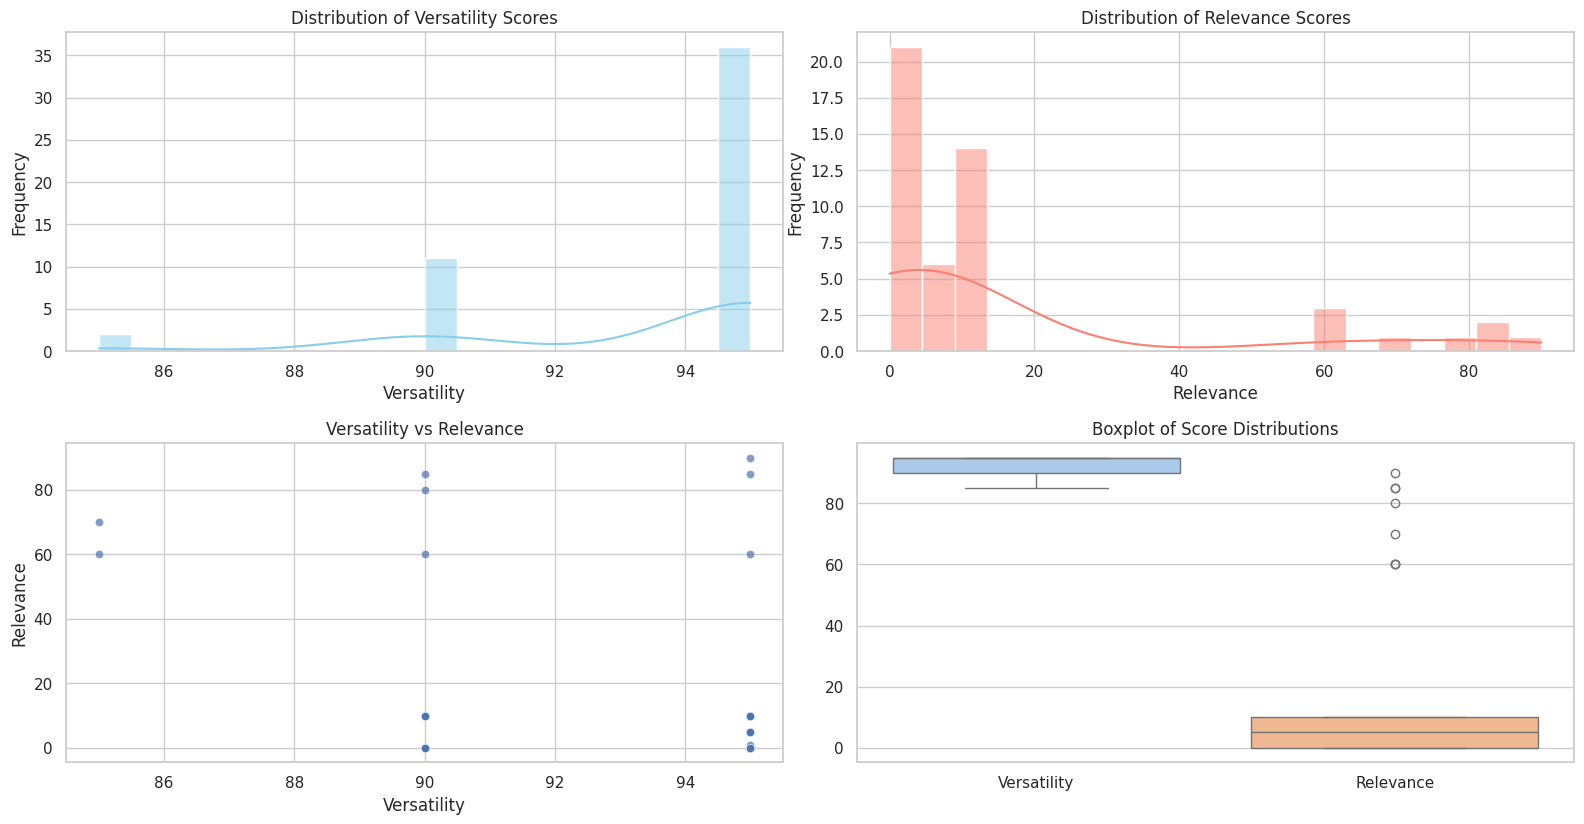

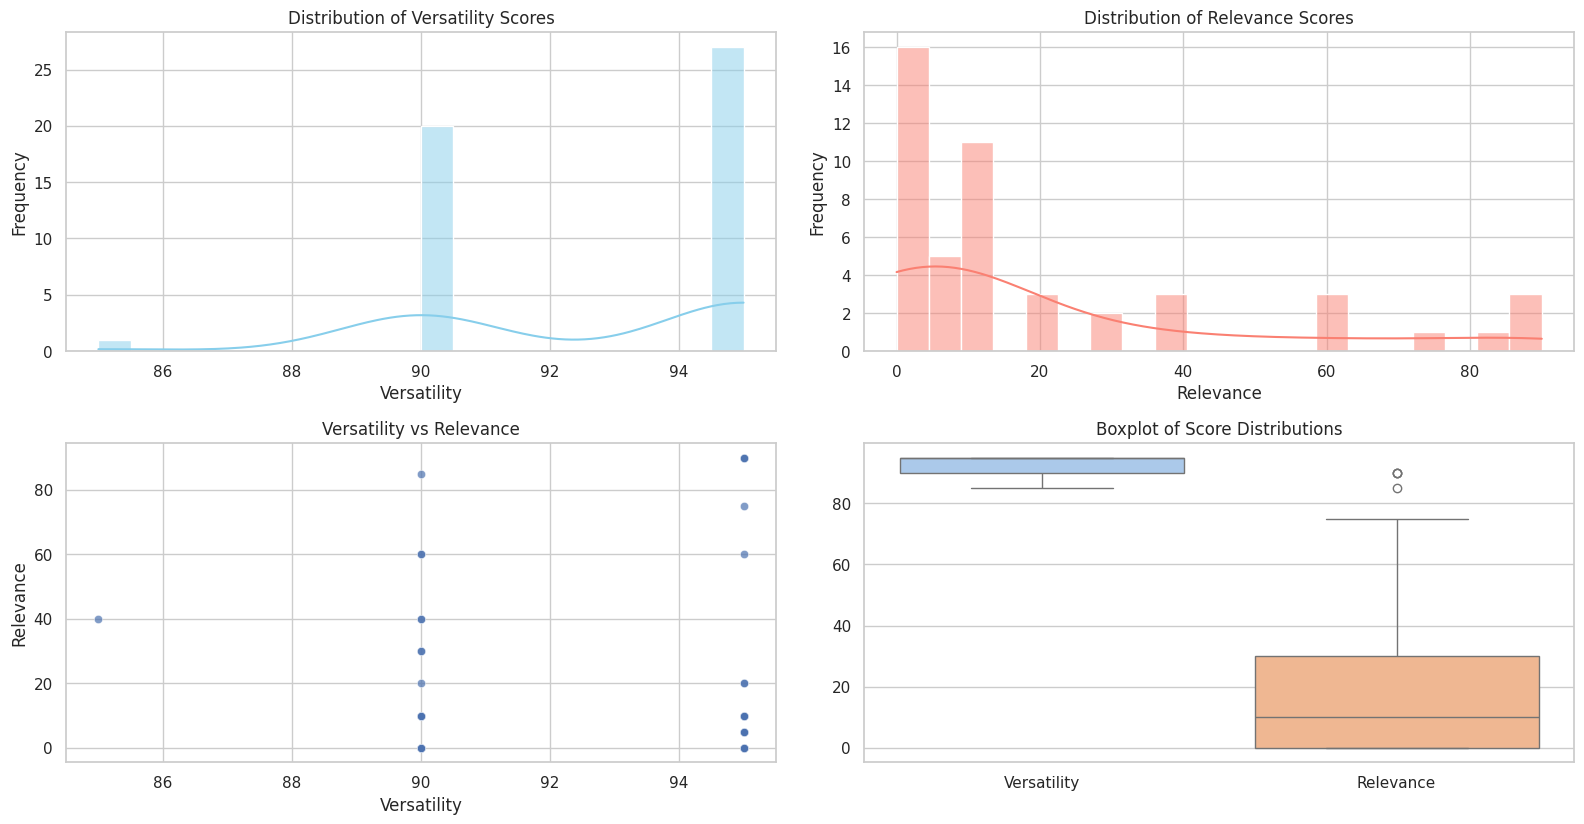

In [ ]:
# create_graphs("/content/gemini-bert_ratings.csv")
# print()
# create_graphs("/content/gemini-roberta_ratings.csv")
# print()
# create_graphs("/content/llama-bert_ratings.csv")
# print()
# create_graphs("/content/llama-roberta_ratings.csv")
# print()
create_graphs("/content/krutrim-bert_ratings.csv")
print()
create_graphs("/content/krutrim-roberta_ratings.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# File mappings
llms = ['llama', 'krutrim', 'gemini']
embeddings = ['bert', 'roberta']
base_path = '.'  # Change if files are in a different folder
save_dir = "comparative_plots"
os.makedirs(save_dir, exist_ok=True)

# Load data
data = []
for llm in llms:
    for emb in embeddings:
        filename = f"{llm}-{emb}_ratings.csv"
        if os.path.exists(filename):
            df = pd.read_csv(filename)
            df.columns = ['Query', 'Versatility', 'Relevance']
            df['LLM'] = llm.upper()
            df['Embedding'] = emb.upper()
            data.append(df)
        else:
            print(f"Missing: {filename}")

df_all = pd.concat(data, ignore_index=True)
sns.set(style="whitegrid")

# ========== 1. Compare Embedding Models for Each LLM ==========
for llm in llms:
    llm_name = llm.upper()
    subset = df_all[df_all['LLM'] == llm_name]

    # Boxplot figure
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"{llm_name} – Embedding Comparison (Boxplots)", fontsize=16)

    plt.subplot(1, 2, 1)
    sns.boxplot(data=subset, x='Embedding', y='Versatility', palette='Set2')
    plt.title("Versatility Score")

    plt.subplot(1, 2, 2)
    sns.boxplot(data=subset, x='Embedding', y='Relevance', palette='Set2')
    plt.title("Relevance Score")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"{save_dir}/{llm_name}_embedding_comparison_boxplot.png")
    plt.close()

    # Violin plot figure
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"{llm_name} – Embedding Comparison (Violin Plots)", fontsize=16)

    plt.subplot(1, 2, 1)
    sns.violinplot(data=subset, x='Embedding', y='Versatility', palette='Set2', inner='box')
    plt.title("Versatility Score")

    plt.subplot(1, 2, 2)
    sns.violinplot(data=subset, x='Embedding', y='Relevance', palette='Set2', inner='box')
    plt.title("Relevance Score")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"{save_dir}/{llm_name}_embedding_comparison_violin.png")
    plt.close()

# ========== 2. Compare LLMs for Each Embedding Model ==========
for emb in embeddings:
    emb_name = emb.upper()
    subset = df_all[df_all['Embedding'] == emb_name]

    # Boxplot figure
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"{emb_name} – LLM Comparison (Boxplots)", fontsize=16)

    plt.subplot(1, 2, 1)
    sns.boxplot(data=subset, x='LLM', y='Versatility', palette='Set3')
    plt.title("Versatility Score")

    plt.subplot(1, 2, 2)
    sns.boxplot(data=subset, x='LLM', y='Relevance', palette='Set3')
    plt.title("Relevance Score")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"{save_dir}/{emb_name}_llm_comparison_boxplot.png")
    plt.close()

    # Violin plot figure
    plt.figure(figsize=(14, 6))
    plt.suptitle(f"{emb_name} – LLM Comparison (Violin Plots)", fontsize=16)

    plt.subplot(1, 2, 1)
    sns.violinplot(data=subset, x='LLM', y='Versatility', palette='Set3', inner='box')
    plt.title("Versatility Score")

    plt.subplot(1, 2, 2)
    sns.violinplot(data=subset, x='LLM', y='Relevance', palette='Set3', inner='box')
    plt.title("Relevance Score")

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.savefig(f"{save_dir}/{emb_name}_llm_comparison_violin.png")
    plt.close()

<ipython-input-16-5e3924c7974c>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Embedding', y='Versatility', palette='Set2')
<ipython-input-16-5e3924c7974c>:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=subset, x='Embedding', y='Relevance', palette='Set2')
<ipython-input-16-5e3924c7974c>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=subset, x='Embedding', y='Versatility', palette='Set2', inner='box')
<ipython-input-16-5e3924c7974c>:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprec

In [ ]:
import pandas as pd
import os

# Setup
llms = ['llama', 'krutrim', 'gemini']
embeddings = ['bert', 'roberta']
summary_csv = "llm_embedding_summary.csv"

# Load data
data = []
for llm in llms:
    for emb in embeddings:
        filename = f"{llm}-{emb}_ratings.csv"
        if os.path.exists(filename):
            df = pd.read_csv(filename)
            df.columns = ['Query', 'Versatility', 'Relevance']
            df['LLM'] = llm.upper()
            df['Embedding'] = emb.upper()
            data.append(df)
        else:
            print(f"Missing: {filename}")

# Concatenate all data
df_all = pd.concat(data, ignore_index=True)

# Compute average scores
summary_table = (
    df_all.groupby(['LLM', 'Embedding'])
    .agg(Average_Versatility=('Versatility', 'mean'),
         Average_Relevance=('Relevance', 'mean'))
    .round(2)
    .reset_index()
)

# Display and save the summary table
print(summary_table)
summary_table.to_csv(summary_csv, index=False)


       LLM Embedding  Average_Versatility  Average_Relevance
0   GEMINI      BERT                75.85              91.26
1   GEMINI   ROBERTA                66.33              89.78
2  KRUTRIM      BERT                93.47              15.53
3  KRUTRIM   ROBERTA                92.71              20.52
4    LLAMA      BERT                60.82              69.80
5    LLAMA   ROBERTA                55.83              65.62


In [ ]:
import pandas as pd
import os

# Setup
llms = ['llama', 'krutrim', 'gemini']
embeddings = ['bert', 'roberta']

# Load data
data = []
for llm in llms:
    for emb in embeddings:
        filename = f"{llm}-{emb}_ratings.csv"
        if os.path.exists(filename):
            df = pd.read_csv(filename)
            df.columns = ['Query', 'Versatility', 'Relevance']
            df['LLM'] = llm.upper()
            df['Embedding'] = emb.upper()
            data.append(df)
        else:
            print(f"Missing: {filename}")

# Combine all data
df_all = pd.concat(data, ignore_index=True)

# Compute pivot tables
versatility_table = df_all.pivot_table(
    index='LLM', columns='Embedding', values='Versatility', aggfunc='mean'
).round(2)

relevance_table = df_all.pivot_table(
    index='LLM', columns='Embedding', values='Relevance', aggfunc='mean'
).round(2)

# Print the tables
print("=== Average Versatility Scores ===")
print(versatility_table)
print("\n=== Average Relevance Scores ===")
print(relevance_table)

# Save the tables as CSV
versatility_table.to_csv("versatility_score_table.csv")
relevance_table.to_csv("relevance_score_table.csv")


=== Average Versatility Scores ===
Embedding   BERT  ROBERTA
LLM                      
GEMINI     75.85    66.33
KRUTRIM    93.47    92.71
LLAMA      60.82    55.83

=== Average Relevance Scores ===
Embedding   BERT  ROBERTA
LLM                      
GEMINI     91.26    89.78
KRUTRIM    15.53    20.52
LLAMA      69.80    65.62
